In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import time


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_range = 150
test_range = 50

In [4]:
class CSVDataset(torch.utils.data.Dataset):
    """ Diabetes dataset."""
    
    # Initialize your data, download, etc.
    def __init__(self):
        xy = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/Quantum hackerton/vigenere_8_train_250.csv',
                        delimiter=',', dtype=np.float32)
        self.len = train_range
        print(xy.shape)
        self.x_data = torch.from_numpy(xy[:train_range, 1:17])
        self.y_data = torch.from_numpy(xy[:train_range, 0])
        print((self.x_data.shape))
        #print(self.y_data)
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len


dataset = CSVDataset()
train_loader = torch.utils.data.DataLoader(dataset=dataset,
                          batch_size=8,
                          shuffle=False,
                            drop_last = True)


(250, 17)
torch.Size([150, 16])


In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.input = nn.Linear(16, 64)
        self.dropout = nn.Dropout2d(p=0.2)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.input(x))
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        x = torch.sigmoid(x)
        
        return x  


In [10]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.BCELoss()

epochs = 20
loss_list = []
model.train()
ts = time.time()

for epoch in range(epochs):

    total_loss = []
    for batch_idx, x in enumerate(train_loader):
        data, target = x
        target = target.unsqueeze(1)

        optimizer.zero_grad()

        output = model(data)

        loss = loss_func(output, target)

        loss.backward()

        optimizer.step()
        
        total_loss.append(loss.item())

    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))

te = time.time()
print('runtime: {:2.2f}sec'.format(te-ts))

Training [5%]	Loss: 0.6916
Training [10%]	Loss: 0.6855
Training [15%]	Loss: 0.6821
Training [20%]	Loss: 0.6743
Training [25%]	Loss: 0.6618
Training [30%]	Loss: 0.6530
Training [35%]	Loss: 0.6355
Training [40%]	Loss: 0.6161
Training [45%]	Loss: 0.5989
Training [50%]	Loss: 0.5707
Training [55%]	Loss: 0.5399
Training [60%]	Loss: 0.5177
Training [65%]	Loss: 0.4854
Training [70%]	Loss: 0.4664
Training [75%]	Loss: 0.4497
Training [80%]	Loss: 0.4000
Training [85%]	Loss: 0.3774
Training [90%]	Loss: 0.3376
Training [95%]	Loss: 0.3061
Training [100%]	Loss: 0.2658
runtime: 0.33sec


Text(0, 0.5, 'Neg Log Likelihood Loss')

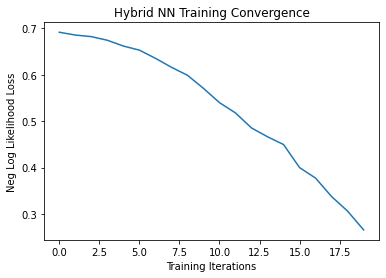

In [11]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [12]:
class CSVDataset(torch.utils.data.Dataset):
    """ Diabetes dataset."""

    # Initialize your data, download, etc.
    def __init__(self):
        xy = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/Quantum hackerton/vigenere_8_test_50.csv',
                        delimiter=',', dtype=np.float32)
        self.len = test_range
        self.x_data = torch.from_numpy(xy[:test_range, 1:17])
        self.y_data = torch.from_numpy(xy[:test_range, 0])

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len


dataset = CSVDataset()
test_loader = torch.utils.data.DataLoader(dataset=dataset,
                          batch_size=8,
                          shuffle=False,
                            drop_last=True)

In [13]:
import math
model.eval()
with torch.no_grad():
    
    correct = 0

    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        pred = output
        target = target.unsqueeze(1)
        for i in range(8):
            if (output[i] > 0.5):
                pred[i] = math.ceil(output[i])
            else:
                pred[i] = math.floor(output[i])
        correct += pred.eq(target.view_as(pred)).sum().item()
        loss = loss_func(output, target)
        total_loss.append(loss.item())
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(dataset) * 100)
        )

Performance on test data:
	Loss: 5.4077
	Accuracy: 76.0%
